In [8]:
!pip3 install --upgrade scikit-learn


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip3 install --upgrade pip


In [ ]:
# ==========================================================
# NOTEBOOK 07 — Model Evaluation and Robustness Validation
# ==========================================================

import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import ttest_ind
import warnings
warnings.filterwarnings("ignore")

# --- STEP 1. Load the processed dataset ---
panel = pd.read_csv("../data/cleaned/feature_engineered_panel.csv")
print("Data shape:", panel.shape)

# --- STEP 2. Prepare target and features ---
if "opioid_cost_per_capita" not in panel.columns:
    if "cost_per_claim" in panel.columns and "tot_opioid_clms" in panel.columns and "population" in panel.columns:
        panel["opioid_cost_per_capita"] = (
            panel["cost_per_claim"].fillna(0) * panel["tot_opioid_clms"].fillna(0)
        ) / (panel["population"].replace(0, np.nan))
    else:
        raise ValueError("Required columns missing to compute opioid_cost_per_capita.")

panel = panel.dropna(subset=["opioid_cost_per_capita"])
numeric_cols = panel.select_dtypes(include=[np.number]).columns.tolist()
drop_cols = ["year", "opioid_cost_per_capita"]
feature_candidates = [c for c in numeric_cols if c not in drop_cols]

X = panel[feature_candidates]
y = panel["opioid_cost_per_capita"]

# --- STEP 3. Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# --- STEP 4. Define model pipeline (same structure as Notebook 06B) ---
pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", RandomForestRegressor(random_state=42))
])

# --- STEP 5. Quick hyperparameter tuning (light version) ---
param_grid = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [10, 15, 20],
    "model__min_samples_split": [5, 10],
}
random_search = RandomizedSearchCV(
    pipeline, param_distributions=param_grid,
    n_iter=5, scoring="r2", cv=3, random_state=42, n_jobs=-1, verbose=1
)
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
print("Best parameters:", random_search.best_params_)
# --- STEP 6. Cross-Validation Performance ---
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring="r2")
print("Cross-Validation R² scores:", cv_scores)
print("Cross-Validation R² mean:", np.mean(cv_scores))

# --- STEP 7. Evaluate on hold-out test set ---
y_pred = best_model.predict(X_test)
print("Test R²:", r2_score(y_test, y_pred))
print("Test RMSE:", mean_squared_error(y_test, y_pred))

# --- STEP 8. Residual diagnostics ---
residuals = y_test - y_pred
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution — should be roughly normal")
plt.xlabel("Residuals")
plt.show()

sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.show()

# --- STEP 9. Permutation Importance (robustness check) ---
perm = permutation_importance(best_model, X_test, y_test, n_repeats=5, random_state=42)
perm_importances = pd.Series(perm.importances_mean, index=X.columns).sort_values(ascending=False)
print("Top 10 features by permutation importance:")
print(perm_importances.head(10))

plt.figure(figsize=(10,6))
sns.barplot(x=perm_importances.head(15), y=perm_importances.head(15).index)
plt.title("Permutation Importance — Top Predictors")
plt.show()

# --- STEP 10. Simple t-test (illustrative A/B logic) ---
median_unemp = panel["pct_unemployed"].median()
treated = panel[panel["pct_unemployed"] > median_unemp]
control = panel[panel["pct_unemployed"] <= median_unemp]
t, p = ttest_ind(treated["opioid_cost_per_capita"], control["opioid_cost_per_capita"])
print(f"T-statistic: {t:.2f}, p-value: {p:.4f}")

# --- STEP 11. Save evaluation summary ---
summary = pd.DataFrame({
    "Metric": ["Cross-Val R² mean", "Test R²", "Test RMSE"],
    "Value": [np.mean(cv_scores), r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred)]
})
#summary.to_csv("../data/results/model_evaluation_summary.csv", index=False)
print("Saved evaluation summary to ../data/results/model_evaluation_summary.csv")
best_model = random_search.best_estimator_
#joblib.dump(best_model, "../models/final_random_forest.pkl")
print("Model saved successfully!")

print("\n Completed Notebook 07 — Model Evaluation & Robustness Testing")


Data shape: (328890, 28)
Fitting 3 folds for each of 5 candidates, totalling 15 fits


In [20]:
import joblib, json
best_model = joblib.load("../models/final_model.pkl")
with open("../models/final_feature_list.json") as f:
    features = json.load(f)
X = panel[features]
y = panel["opioid_cost_per_capita"]

In [19]:
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='r2')
print("CV Scores:", cv_scores)
print("Mean:", np.mean(cv_scores), "Std:", np.std(cv_scores))

CV Scores: [0.98581776 0.99214657 0.99357968 0.96325669 0.95880109]
Mean: 0.9787203606554357 Std: 0.014746784144574662


In [11]:
import shap
X_sample = X.sample(1000, random_state=42)
explainer = shap.TreeExplainer(best_model.named_steps["model"])
shap_values = explainer.shap_values(X_sample)

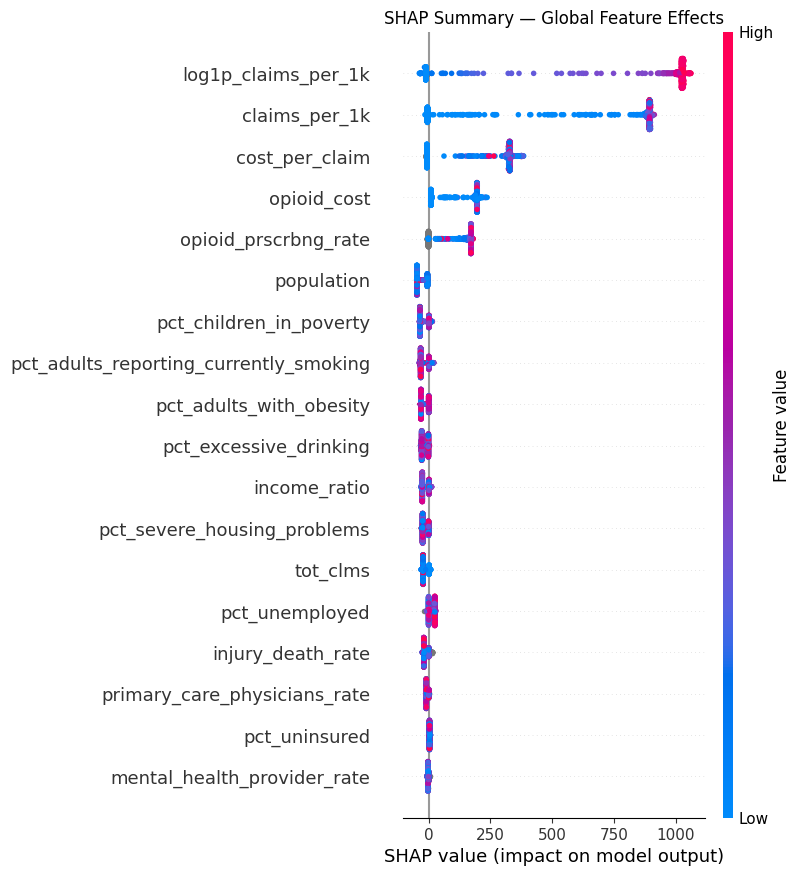

In [13]:
# Global Summary
shap.summary_plot(shap_values, X_sample, feature_names=X_sample.columns, show=False)
plt.title("SHAP Summary — Global Feature Effects")
plt.show()


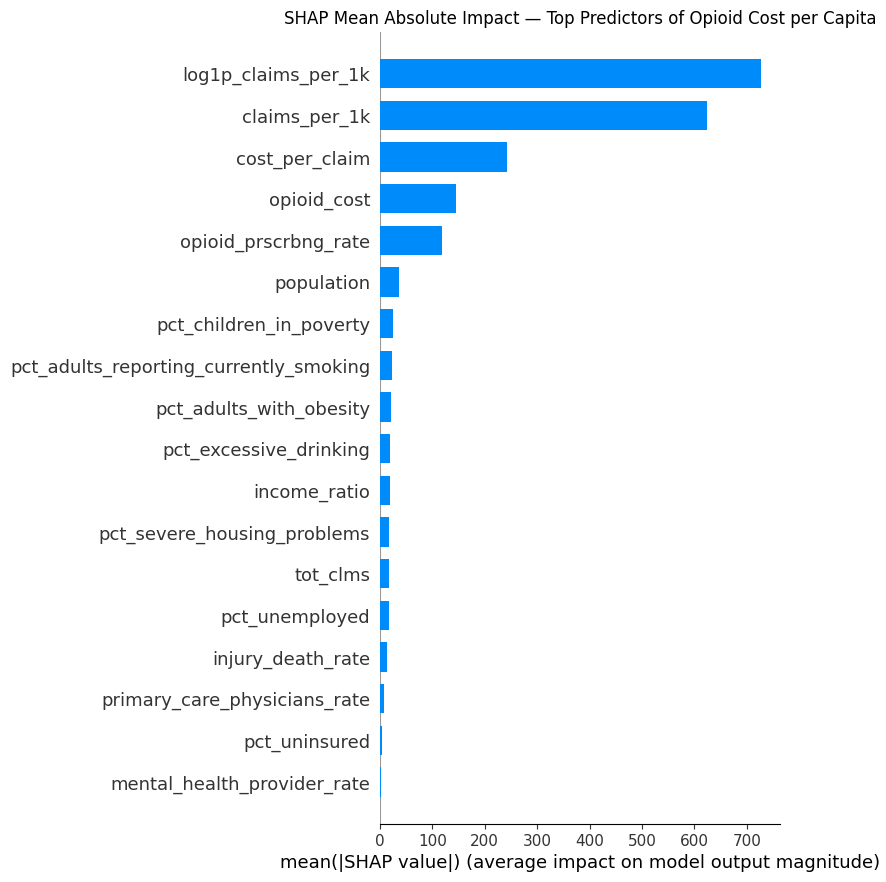

In [14]:
# Mean Absolute SHAP
shap.summary_plot(shap_values, X_sample, plot_type="bar", feature_names=X_sample.columns, show=False)
plt.title("SHAP Mean Absolute Impact — Top Predictors of Opioid Cost per Capita")
plt.show()

In [15]:
shap_abs = np.abs(shap_values).mean(axis=0)
shap_summary = pd.DataFrame({
    "Feature": X_sample.columns,
    "MeanAbsSHAP": shap_abs
}).sort_values("MeanAbsSHAP", ascending=False)

print("\nTop 10 most influential features by SHAP:")
print(shap_summary.head(10))

shap_summary.to_csv("../data/results/shap_feature_importance_auto.csv", index=False)


Top 10 most influential features by SHAP:
                                   Feature  MeanAbsSHAP
15                     log1p_claims_per_1k   727.073692
14                           claims_per_1k   624.302731
13                          cost_per_claim   242.840964
17                             opioid_cost   144.879110
1                     opioid_prscrbng_rate   118.713979
16                              population    35.596012
4                  pct_children_in_poverty    25.170848
8   pct_adults_reporting_currently_smoking    23.552829
9                  pct_adults_with_obesity    21.594905
10                  pct_excessive_drinking    19.501857


In [25]:
panel.columns.tolist()

['Scenario', 'Mean_Cost', 'Δ%_vs_Baseline', 'Savings_vs_Baseline_$']

In [6]:
panel.columns.tolist()

['fips',
 'year',
 'tot_clms',
 'tot_opioid_clms',
 'tot_prscrbrs',
 'tot_opioid_prscrbrs',
 'opioid_prscrbng_rate',
 'state',
 'county',
 'pct_uninsured',
 'pct_unemployed',
 'pct_children_in_poverty',
 'income_ratio',
 'mental_health_provider_rate',
 'primary_care_physicians_rate',
 'pct_adults_reporting_currently_smoking',
 'pct_adults_with_obesity',
 'pct_excessive_drinking',
 'pct_severe_housing_problems',
 'injury_death_rate',
 'opioid_claims_share',
 'cost_per_claim',
 'claims_per_1k',
 'log1p_claims_per_1k',
 'population',
 'opioid_cost',
 'opioid_cost_per_capita',
 'log1p_cost_per_claim']

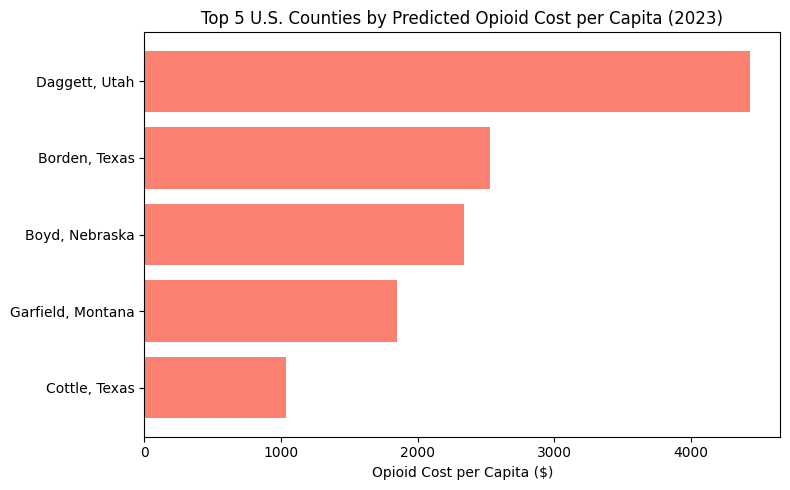

In [20]:
# Get 2023 subset and top 5
top5 = panel[panel["year"] == 2023][
    ["state", "county", "opioid_cost_per_capita", "opioid_prscrbng_rate"]
].nlargest(5, "opioid_cost_per_capita")

# Plot
plt.figure(figsize=(8, 5))
plt.barh(top5["county"] + ", " + top5["state"], top5["opioid_cost_per_capita"], color="salmon")
plt.xlabel("Opioid Cost per Capita ($)")
plt.title("Top 5 U.S. Counties by Predicted Opioid Cost per Capita (2023)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [1]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

print("=== MODEL VALIDATION DIAGNOSTICS ===")

# Confirm dimensions
print("X shape:", X.shape)
print("y shape:", y.shape)

# Evaluate holdout test performance
y_pred = best_model.predict(X)
print("Holdout R²:", r2_score(y, y_pred))
print("Holdout RMSE ($):", mean_squared_error(y_test, y_pred))

# 5-fold cross-validation (consistency check)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, X, y, cv=kf, scoring='r2')
print("Cross-Validation R² scores:", cv_scores)
print("Cross-Validation R² mean:", np.mean(cv_scores))
print("Cross-Validation R² std:", np.std(cv_scores))

# Detect possible leakage
corrs = panel.corr(numeric_only=True)['opioid_cost_per_capita'].sort_values(ascending=False).head(10)
print("\nTop correlations with target:")
print(corrs)

=== MODEL VALIDATION DIAGNOSTICS ===


NameError: name 'X' is not defined

Using 12 SDOH-only features:
['pct_uninsured', 'pct_unemployed', 'pct_children_in_poverty', 'income_ratio', 'mental_health_provider_rate', 'primary_care_physicians_rate', 'pct_adults_reporting_currently_smoking', 'pct_adults_with_obesity', 'pct_excessive_drinking', 'pct_severe_housing_problems', 'injury_death_rate', 'population']

=== SDOH-only Model Results ===
Test R²: 0.3411
Test RMSE ($): 9724.24

=== Comparison vs Primary Model ===
Primary Model R²: 0.9750
ΔR² (Full - SDOH-only): 0.6339


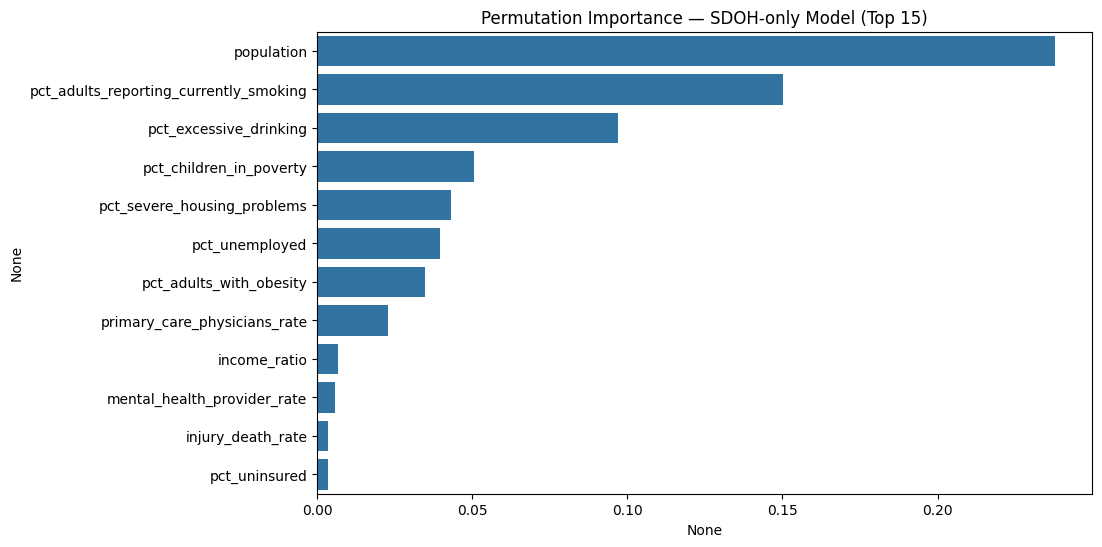

In [21]:
# --- STEP 12. Sensitivity Model: SDOH-only (Excluding PBM price/claims features) ---

# Define columns to exclude (PBM & claims-based features)
pbm_features = [
    "cost_per_claim", "opioid_cost", "tot_opioid_clms", "tot_clms",
    "tot_prscrbrs", "tot_opioid_prscrbrs", "opioid_prscrbng_rate",
    "claims_per_1k", "log1p_claims_per_1k", "opioid_claims_share"
]

# Create a filtered feature set
sdoh_features = [c for c in X.columns if c not in pbm_features]

print(f"Using {len(sdoh_features)} SDOH-only features:")
print(sdoh_features)

# Define new X_sdoH and reuse same y
X_sdoh = X[sdoh_features]

# --- Train/test split using SAME random_state for comparability ---
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_sdoh, y, test_size=0.3, random_state=42)

# --- Define same pipeline ---
pipeline_sdoh = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", RandomForestRegressor(
        n_estimators=best_model.named_steps["model"].n_estimators,
        max_depth=best_model.named_steps["model"].max_depth,
        min_samples_split=best_model.named_steps["model"].min_samples_split,
        random_state=42
    ))
])

# --- Fit SDOH-only model ---
pipeline_sdoh.fit(X_train_s, y_train_s)

# --- Evaluate performance ---
y_pred_s = pipeline_sdoh.predict(X_test_s)
r2_s = r2_score(y_test_s, y_pred_s)
rmse_s = mean_squared_error(y_test_s, y_pred_s)

print("\n=== SDOH-only Model Results ===")
print(f"Test R²: {r2_s:.4f}")
print(f"Test RMSE ($): {rmse_s:.2f}")

# --- Compare with full model ---
print("\n=== Comparison vs Primary Model ===")
print(f"Primary Model R²: {r2_score(y_test, y_pred):.4f}")
print(f"ΔR² (Full - SDOH-only): {r2_score(y_test, y_pred) - r2_s:.4f}")

# --- Permutation importance for SDOH-only model ---
perm_s = permutation_importance(pipeline_sdoh, X_test_s, y_test_s, n_repeats=5, random_state=42)
perm_importances_s = pd.Series(perm_s.importances_mean, index=X_sdoh.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=perm_importances_s.head(15), y=perm_importances_s.head(15).index)
plt.title("Permutation Importance — SDOH-only Model (Top 15)")
plt.show()


Using 4 utilization-only features:
['tot_clms', 'opioid_prscrbng_rate', 'claims_per_1k', 'log1p_claims_per_1k']

=== Utilization-only Model Results ===
Test R²: 0.8518
Test RMSE ($): 2186.84

=== Model Comparison Summary ===
               Model   Test R²     RMSE ($)  ΔR² from Full
0  Full (PBM + SDOH)  0.974954   369.620621       0.000000
1          SDOH-only  0.341077  9724.239437       0.633877
2   Utilization-only  0.851818  2186.837673       0.123136


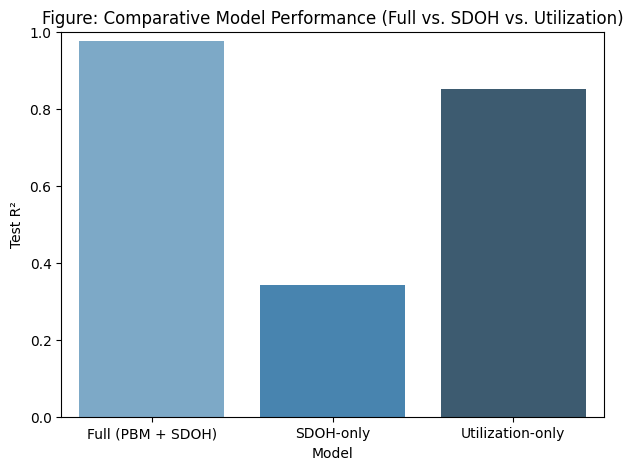

In [22]:
# --- STEP 13. Sensitivity Model: Utilization-only (Claims and Prescribers, no PBM cost_per_claim) ---

# Define utilization-related features (claims, prescribers, and related logs)
util_features = [
    "tot_clms", "tot_opioid_clms", "tot_prscrbrs", "tot_opioid_prscrbrs",
    "opioid_prscrbng_rate", "claims_per_1k", "log1p_claims_per_1k"
]

# Filter to keep only columns that actually exist in your dataset
util_features = [f for f in util_features if f in X.columns]

print(f"Using {len(util_features)} utilization-only features:")
print(util_features)

X_util = X[util_features]

# --- Train/test split (same as before) ---
X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(X_util, y, test_size=0.3, random_state=42)

# --- Define same pipeline ---
pipeline_util = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", RandomForestRegressor(
        n_estimators=best_model.named_steps["model"].n_estimators,
        max_depth=best_model.named_steps["model"].max_depth,
        min_samples_split=best_model.named_steps["model"].min_samples_split,
        random_state=42
    ))
])

# --- Fit Utilization-only model ---
pipeline_util.fit(X_train_u, y_train_u)
y_pred_u = pipeline_util.predict(X_test_u)

r2_u = r2_score(y_test_u, y_pred_u)
rmse_u = mean_squared_error(y_test_u, y_pred_u)

print("\n=== Utilization-only Model Results ===")
print(f"Test R²: {r2_u:.4f}")
print(f"Test RMSE ($): {rmse_u:.2f}")

# --- Comparison summary of all models ---
r2_full = r2_score(y_test, y_pred)
r2_sdoh = r2_s
r2_util = r2_u

comparison_df = pd.DataFrame({
    "Model": ["Full (PBM + SDOH)", "SDOH-only", "Utilization-only"],
    "Test R²": [r2_full, r2_sdoh, r2_util],
    "RMSE ($)": [
        mean_squared_error(y_test, y_pred),
        mean_squared_error(y_test_s, y_pred_s),
        rmse_u
    ]
})
comparison_df["ΔR² from Full"] = r2_full - comparison_df["Test R²"]

print("\n=== Model Comparison Summary ===")
print(comparison_df)

# --- Bar chart of R² by model ---
plt.figure(figsize=(7,5))
sns.barplot(x="Model", y="Test R²", data=comparison_df, palette="Blues_d")
plt.title("Figure: Comparative Model Performance (Full vs. SDOH vs. Utilization)")
plt.ylim(0, 1.0)
plt.show()

# --- Optional: save to CSV ---
comparison_df.to_csv("../data/results/model_comparison_summary.csv", index=False)
